# Projection Theory
*Arthur Ryman, lasted updated 2025-09-04*

## Introduction

The goal of this notebook is to analyze and develop the theory of projections as originally outlined in the document 
[projection.md](https://github.com/agryman/instant-insanity/blob/main/src/instant_insanity/core/projection.md).

## Motivation

Although work is underway in the Manim Community 
to produce a high-quality OpenGL renderer for use with the `ThreeDScene` class,
the majority of our planned content is 2d so using Cairo with the `Scene` class
in conjunction with projections from 3d model space to 2d scene space with depth-sorting
is an acceptable short-term workaround.

## SymPy

I will use SymPy to represent and verify the math.
I will convert the notation used in the original document to a notation that SymPy easily handles, namely using
numeric subscripts for components of vectors.

SymPy provides two sets of classes that are relevant to this calculation.
The Matrix class and friends is ideal for performining vector space calculations.
The geometry module is ideal for euclidean geometry calculations involving points, lines, and planes.
We'll use both.

## Scalars and Vectors

Model space and scene space are 3-dimensional real vector spaces, that is they are copies of $\mathbb{R}^3$.

Define the types Scalar to be a real number and Vector to be a triple of scalars.
SymPy represents vectors as matrices that have a single column, i.e. as column vectors.

Define some convenience functions to create scalars, positive scalars, and vectors.
We'll use the numbers 1, 2, and 3 to subscript the components of vectors.

In [1]:
from sympy import *
from instant_insanity.core.symbolic_projection import Scalar, Vector

def scalar(name: str) -> Scalar:
    return symbols(name, real=True)

def positive_scalar(name: str) -> Scalar:
    return symbols(name, real=True, positive=True)

def vector(name: str) -> Vector:
    return Matrix(symbols(name + '1:4', real=True))

## Model Space

Let $M$ denote the 3d model space.
Model space is where our simple 3d objects live.

SymPy provides a CoordSys3D class for representing vector spaces.
It might be useful to use it, but I'll defer that for now.

Let $x, y, z$ be the usual Cartesian coordinates on model space.

We will use the default Manim orientation of model space relative to the display screen, 
namely:
* $x$ increases from left (LEFT) to right (RIGHT),
* $y$ increases from bottom (DOWN) to top (UP), and 
* $z$ increases from in back (IN) to front (OUT).

Let $m$ represent an arbitrary point in model space.

In [2]:
model_point = m = vector('m')

m.T

Matrix([[m1, m2, m3]])

In [3]:
type(m)

sympy.matrices.dense.MutableDenseMatrix

In [4]:
m1, m2, m3 = m

m3

m3

## Projections

Our goal is to draw 3d objects, e.g. a cube, that live in model space $M$ as 2d objects, 
e.g. a polygon, on the camera plane $C$.
A projection is a mapping from $M$ to $C$ that reproduces the visual appearance of the 3d object as a 2d object.

However, we need to draw the 2d projections of our 3d objects in the correct order to achieve the correct appearance.
If object A is behind object B in model space then we need to draw the 2d projection
of object A before we draw that of object B. 
This way part of object may cover part of object A, reproducing what we actually see.
This procedure is known as the 
[Painter's Algorithm](https://en.wikipedia.org/wiki/Painter%27s_algorithm).

For simplicity, we will assume that our 3d objects can be modelled as collections of opaque, convex, planar
polygons and that we can always sort them into some drawing order that will produce the correct visual appearance.

Note that it is possible to arrange three nonintersecting, convex, 
planar polygons in a way that has no corresponding correct drawing order.

Given the known requirements for our current project, 
all collections of 3d objects will be simple enough so that a correct
drawing order always exists.

If we actually needed to draw some collection of polygons that had no correct drawing order,
then we would have to split some of the polygons.
If we split the polygons enough then a correct drawing order always exists.
In the extreme case, we could split each polygon into individual pixels.
We'll defer dealing with this situation until project requirements force us to do so.

## Projective Linear Transformations

Here is the geometric setup.

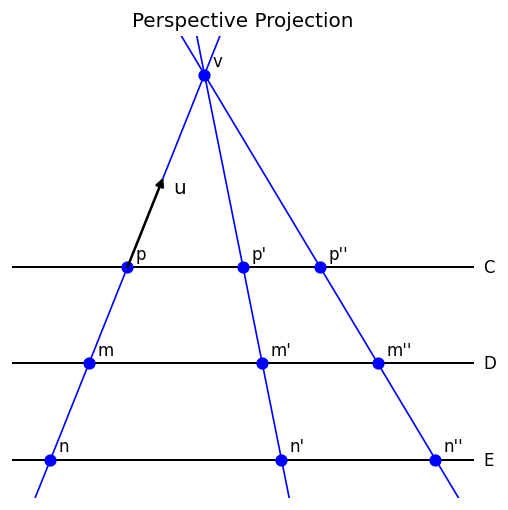

In [5]:
from instant_insanity.core.projection_diagram import create_projection_diagram

create_projection_diagram()

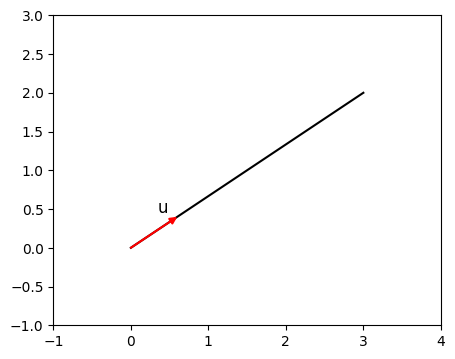

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

A = (0, 0)
B = (3, 2)

# Draw the line AB
ax.plot([A[0], B[0]], [A[1], B[1]], color='black')

# Vector from A to B
dx, dy = (B[0] - A[0]), (B[1] - A[1])
scale = 0.2   # fraction of AB length to use for arrow length

# Arrow endpoint (short arrow pointing from A toward B)
x2 = A[0] + dx * scale
y2 = A[1] + dy * scale

# Draw the arrow
ax.annotate(
    '', 
    xy=(x2, y2),   # arrow head
    xytext=A,      # arrow tail
    arrowprops=dict(
        arrowstyle='-|>',   # simple arrow head
        color='red',
        lw=1.5,
        shrinkA=0, shrinkB=0
    )
)

# Label "u" at the tip
ax.text(
    x2 - 0.25, y2, 'u',
    fontsize=12,
    ha='left', va='bottom',  # position relative to the point
    color='black'
)



ax.set_xlim(-1, 4)
ax.set_ylim(-1, 3)
plt.show()

In our context, a 3d projection 
$$f: M \rightarrow M$$
is projective linear transformation of model space that preserves $z$-coordinates.

Let $$m \in M$$ map to: $$f(m) = n \in M$$

Let $$m = (m_1, m_2, m_3)$$ 
and let 
$$f(m) = n = (n_1, n_2, n_3)$$
be its projection.
Then we require:
$$m_3 = n_3$$ 
This means that the $z$-depth of the point hasn't changed,
only its $(x, y)$ coordinates.

Let $m$ and $m'$ be distinct points in model space that project to the same
point in the camera plane:
$$\pi(f(m)) = \pi(f(m'))$$

We say that $m$ and $m'$ are *collinear* with respect to $f$.

Suppose that $m$ is behind $m'$.
Denote this as:
$$ m \prec m'$$

We will define a real-valued $t_f$ function for $f$ 
$$ t_f: M \rightarrow \mathbb{R}$$
with the property that it respects
the relative ordering of collinear points in the sense that
their $t_f$ values must satisfy:
$$t_f(m) < t_f(m')$$

There are two commonly used 3d projections, namely perspective and orthographic.
These will be defined next.

## The Camera Plane

Both types of projection are defined by families of lines, which we think of as light rays,
that pass through the camera plane.
We will only consider camera planes that are perpendicular to the z-axis.
The camera plane $C$ is defined by the equation $z = c$ where $c$ is some scalar value.

Let $C$ denote the camera plane in model space.
The camera plane is where we will draw the 2d projections of 3d objects.
The points in the camera plane get mapped to the pixels of the 
display screen by the Manim Scene class.

The camera plane is oriented parallel to the plane z = 0.
Let $c$ be a real number that defines the camera plane 
as the solutions to the equation $z = c$:

$$
C = \{~(x, y, c) \mid (x, y) \in \mathbb{R}^2~\}
$$

In [7]:
camera_z = c = scalar('c')

c

c

An arbitrary point $m$ in model space has $z$-component $m_3$.
The camera plane in model space defined by the parameter $c$ is given by the equation:

$$
m_3 = c
$$

In [8]:
def camera_plane(c: Scalar) -> Eq:
    return Eq(m3, c)

C = camera_plane(c)

C

Eq(m3, c)

Ask SymPy to verify that any point with $z$-component $c$ is contained in the camera plane $C$.

In [9]:
C.subs({m3: c})

True

SymPy may not be able to determine if a point is in the plane, 
in which case the equation does not reduce to a truth value.

For example, a point with $z$-component 0 lies in $C$ exactly when $c = 0$.

In [10]:
C.subs({m3: 0})

Eq(0, c)

Define a function that tests if a point $p$ in model space satisfies an equation defined in terms of the 
arbitrary point $m$ in model space. 

In [11]:
def is_solution(p: Vector, eq: Eq) -> Eq:
    p1, p2, p3 = p
    return eq.subs({m1: p1, m2: p2, m3: p3})

SymPy may be able to reduce the equation to a boolean if it can simplify it enough.
For example, the equation $c = c$ is always true.

In [12]:
p00c = Matrix([0, 0, c])

p00c.T

Matrix([[0, 0, c]])

In [13]:
is_solution(p00c, C)

True

The equation $c = c + 1$ is always false.

In [14]:
p00c1 = Matrix([0, 0, c + 1])

p00c1.T

Matrix([[0, 0, c + 1]])

In [15]:
is_solution(p00c1, C)

False

Given any point $m$ in model space, we define its projection $\pi(c, m)$ onto the camera
plane by:
$$
\pi(c, (m_1, m_2, m_3)) = (m_1, m_2, c)
$$

The variable $\pi$ is predefined in SymPy, so let's call this projection proj_xy.

In [16]:
def proj_xy(c: Scalar, p: Vector) -> Vector:
    return Matrix([p[0], p[1], c])

proj_xy(c, m).T

Matrix([[m1, m2, c]])

Thus, $\pi$ maps $M$ onto $C$:
$$
\pi: M \rightarrow C
$$

The projection $\pi$ does nothing to the $(x,y)$-coordinates
and forgets the $z$-coordinate of points in $M$.

We need more sophisticated projections that give us the illusion of 3d scenes
but don't forget depth information so that we can invert them and compute the relative
ordering of model space points that project to the same camera plane points.
These are referred to as 3d projections, and they include perspective and orthographic
projections.

### SymPy Geometry Classes

SymPy has some classes that are useful for 3d geometry.
These are Point3D, Line3D, and Plane.

Let's define the camera plane using Plane and perform the previous point membership tests.

We can define a Plane by providing a point that lies in it and a vector that is normal to it.

In [17]:
from sympy import Point3D, Line3D, Plane

point_C = Point3D(0, 0, c)

point_C

Point3D(0, 0, c)

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="manim_voiceover")

from manim import OUT

normal_C = Point3D(OUT)

normal_C

Point3D(0, 0, 1)

In [19]:
plane_C = Plane(point_C, normal_vector=normal_C)

plane_C

Plane(Point3D(0, 0, c), (0, 0, 1))

The point we used to construct $C$ is contained in it.
Any point with $z$-component $c$ is contained in $C$.

In [20]:
point_C in plane_C

True

In [21]:
point_p00c = Point3D(p00c)
point_C == point_p00c

True

In [22]:
point_p00c in plane_C

True

Any point with $z$-component $c+1$ is not contained in $C$.

In [23]:
point_p00c1 = Point3D(p00c1)

point_p00c1 in plane_C

False

## Perspective Projections

A perspective projection models the way we see things.
Objects that are further away appear smaller and parallel lines converge.

A perspective projection is defined by a viewpoint $v \in M$.
The viewpoint represents the position of our eyes.

Treat $v$ as a fixed parameter in what follows.
Consider points $m$ that are distinct from $v$.
If $m = v$ then the projection of $m$ is not defined.

### The Viewpoint

We define perspective projections by giving a viewpoint $v$.
Define an arbitrary viewpoint.

In [24]:
viewpoint = v = vector('v')

viewpoint.T

Matrix([[v1, v2, v3]])

Let $L(m,v)$ be the line in model space that passes through the points $m$ and $v$.
This line exists because we have assumed that $m \ne v$.
Define $L(m, v)$ using Line3D.

Start by creating Point3D instances from $m$ and $v$,

In [25]:
point_m = Point3D(m)

point_m

Point3D(m1, m2, m3)

In [26]:
point_v = Point3D(v)

point_v

Point3D(v1, v2, v3)

In [27]:
line_mv = Line3D(point_m, point_v)

line_mv

Line3D(Point3D(m1, m2, m3), Point3D(v1, v2, v3))

Verify that $L(m,v)$ contains both $m$ and $v$.

In [28]:
line_mv.contains(point_m)

True

In [29]:
point_m in line_mv

True

In [30]:
line_mv.contains(point_v)

True

In [31]:
point_v in line_mv

True

Think of $L(m,v)$ as a light ray that leaves the 3d object at 
$m$ and enters our eye at $v$.

Note that $L(m,v)$ does not depend on $c$.

The projection $f(m,v,c)$ is defined in terms of the unique point $r(m,v,c)$ where 
the light ray $L(m,v)$ intersects the camera plane $C$.

$$
L(m,v) \cap C = \{ r(m,v,c) \}
$$

Therefore,
$$
r(m,v,c) = (r(m,v,c)_1, r(m,v,c)_2, c)
$$
where $r(m,v,c)_1$ and $r(m,v,c)_2$ are unknown quantities that we have to compute.

Use SymPy to compute this intersection.

In [32]:
list_rmvc = line_mv.intersection(plane_C)

len(list_rmvc)

1

In general, the intersection of two sets may contain zero or more points.
We get a unique intersection point here as expected.

In [33]:
point_rmvc = list_rmvc[0]

point_rmvc

Point3D(m1 - (-c + m3)*(m1 - v1)/(m3 - v3), m2 - (-c + m3)*(m2 - v2)/(m3 - v3), c)

Work out the math by hand to verify the SymPy answer.

Let $\hat{u}(m,v)$ denote the unit vector that points from $m$ to $v$.
$$
\hat{u}(m,v) = \frac{v - m}{\lVert v - m \rVert}
$$

In [34]:
vector_mv = point_v - point_m

vector_mv

Point3D(-m1 + v1, -m2 + v2, -m3 + v3)

The norm of a vector is its distance from the origin.

In [35]:
origin = Point3D(0, 0, 0)

origin

Point3D(0, 0, 0)

In [36]:
norm_mv = vector_mv.distance(origin)

norm_mv

sqrt((-m1 + v1)**2 + (-m2 + v2)**2 + (-m3 + v3)**2)

In [37]:
vector_umv = vector_mv / norm_mv

vector_umv

Point3D((-m1 + v1)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2), (-m2 + v2)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2), (-m3 + v3)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2))

Let $\hat{u}(m,v)$ have the following components:
$$
\hat{u}(m,v) = (u(m,v)_1, u(m,v)_2, u(m,v)_3)
$$

In [38]:
umv_1, umv_2, umv_3 = vector_umv

umv_3

(-m3 + v3)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2)

Let $\lambda$ denote a real line parameter.

In [39]:
lamda = l = scalar('lambda')

l

lambda

Define $L(m,v,c,\lambda)$ to be the point on $L(m,v)$ parameterized by $\lambda$ as follows:
$$
L(m,v,c,\lambda) = r(m,v,c) + \lambda \hat{u}(m,v)
$$

In [40]:
point_Lmvcl = point_rmvc + l * vector_umv

point_Lmvcl

Point3D(-lambda*(m1 - v1)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2) + m1 + (c - m3)*(m1 - v1)/(m3 - v3), -lambda*(m2 - v2)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2) + m2 + (c - m3)*(m2 - v2)/(m3 - v3), c - lambda*(m3 - v3)/sqrt((m1 - v1)**2 + (m2 - v2)**2 + (m3 - v3)**2))

We can think of the line as being directed from
$m$ to $v$ with $\lambda$ being the distance travelled along the line from 
$r(m,v,c) = L(m,v,c,0)$ to $L(m,v,c,\lambda)$.

By definition, the parameter value $\lambda = 0$ maps to the point $r(m,v,c)$.
$$
L(m,v,c,0) = r(m,v,c)
$$

Verify this using SymPy.

In [41]:
point_Lmvc0 = point_Lmvcl.subs({l: 0})

point_Lmvc0

Point3D(m1 + (c - m3)*(m1 - v1)/(m3 - v3), m2 + (c - m3)*(m2 - v2)/(m3 - v3), c)

In [42]:
point_Lmvc0 - point_rmvc == origin

True

In terms of components, we have:
$$
\begin{align}
L(m,v,c,\lambda)_1 &= \lambda u(m,v)_1 + r(m,v,c)_1 \\
L(m,v,c,\lambda)_2 &= \lambda u(m,v)_2 + r(m,v,c)_2 \\
L(m,v,c,\lambda)_3 &= \lambda u(m,v)_3 + c
\end{align}
$$

Define $t(m,v,c)$ to be the line parameter value $\lambda$ that corresponds to the point $m$.
$$
L(m,v,c,t(m,v,c)) = m
$$

In terms of components, we have
$$
\begin{align}
r(m,v,c)_1 + t(m,v,c) u(m,v)_1 &= m_1 \\
r(m,v,c)_2 + t(m,v,c) u(m,v)_2 &= m_2 \\
c + t(m,v,c) u(m,v)_3 &= m_3
\end{align}
$$

Now solve for $t(m,v,c), r(m,v,c)_1, r(m,v,c)_2$ as follows:
$$
\begin{align}
t(m,v,c) &= \frac{m_3 - c}{u(m,v)_3} \\
r(m,v,c)_1 &= m_1 - t(m,v,c) u(m,v)_1 \\
r(m,v,c)_2 &= m_2 - t(m,v,c) u(m,v)_2
\end{align}
$$

In summary, a viewpoint $v$ defines a 3d projection $f$ as follows:

$$
f(m,v,c) = (r(m,v,c)_1, r(m,v,c)_2, m_3))
$$

Conversely, given a point $(r_1, r_2, m_3)$ we can compute the point $(m_1, m_2, m_3)$

Given $r(m,v,c), m_3$, we can compute $t(m,v,c), m_1, m_2$ as follows:
$$
\begin{align}
t(m,v,c) &= \frac{m_3 - c}{u(r,v)_3} \\
m_1 &= r(m,v,c)_1 + t(m,v) u(r,v)_1 \\
m_2 &= r(m,v,c)_2 + t(m,v) u(r,v)_2
\end{align}
$$

## Orthographic Projection

An orthographic projection is a limiting case of a perspective projection as
the viewpoint $v$ moves off to infinity in a fixed direction.
Let $\hat{u}$ be a unit vector that defines the direction that the viewpoint moves in.
Let $\mu$ be a real parameter, let $v_0$ be an initial viewpoint,
and define the viewpoint $v(\hat{u};\mu)$ as follows:
$$
v(\hat{u};\mu) = v_0 + \mu \hat{u}
$$

Define $\hat{u}(m; \mu)$ to be the unit vector that points from $m$ to $v(\mu)$.
$$
\hat{u}(m; \mu) = \frac{v(\hat{u};\mu) - m}{\lVert v(\hat{u};\mu) - m \rVert}
$$

Clearly, as $\mu$ becomes very large, 
$v(\hat{u};\mu)$ approaches $\mu \hat{v}$.
$$
\begin{align}
\lim_{\mu \to \infty} \hat{u}(m; \mu) 
&= \lim_{\mu \to \infty} \frac{v(\hat{u};\mu) - m}{\lVert v(\hat{u};\mu) - m \rVert} \\
&= \lim_{\mu \to \infty} \frac{v_0 + \mu \hat{u} - m}{\lVert v_0 + \mu \hat{v} - m \rVert} \\
&= \lim_{\mu \to \infty} \frac{\mu \hat{u}}{\lVert \mu \hat{u} \rVert} \\
&= \lim_{\mu \to \infty} \frac{\mu \hat{u}}{\mu \lVert \hat{u} \rVert} \\
&= \hat{u}
\end{align}
$$

Therefore, an orthographic projection is like a perspective projection except that
rather than compute the unit vector $\hat{u}(v;m)$ we use the given constant unit vector $\hat{u}$.

### Spherical Polar Coordinates

We define an orthographic projection by giving the unit vector $u$ that specifies the direction of the projection.
Since we'll be doing exact symbolic mathematics, we'll define the unit vector in terms of spherical polar angles.
Any unit vector $u$ is parameterized by the polar angle $\theta$ and the azimuthal angle $\phi$.

Define an arbitrary unit vector $u$.

In [43]:
theta = scalar('theta')
phi = scalar('phi')

Matrix([theta, phi]).T

Matrix([[theta, phi]])

In [44]:
u_x = sin(theta) * cos(phi)
u_y = sin(theta) * sin(phi)
u_z = cos(theta)
u = Matrix([u_x, u_y, u_z])

u.T

Matrix([[sin(theta)*cos(phi), sin(phi)*sin(theta), cos(theta)]])

In [45]:
u.norm()

sqrt(sin(phi)**2*sin(theta)**2 + sin(theta)**2*cos(phi)**2 + cos(theta)**2)

In [46]:
simplify(u.norm())

1

## Translations and Scalings

Translations allow us to shift the origins of model space and scene space relative to each other.

Scaling allows us to change their relative units of measure.
For example, our standard puzzle cube has side length 2.0 in model space, but might fit better with side length 1.0 in scene space.
In this case we would use a scale factor of 0.5.

Technically, translations and scalings are independent of projections.
Historically, we have introduced the idea of the camera plane.
The position of the camera plane has no impact on the magnification of objects in orthographic projections.
It does influence the magnification in perspective transformations. The closer the camera plane is to the viewpoint,
the smaller it looks. However, I believe this effect can be compensated for by a suitably chosen scale factor.

TODO: Confirm that an arbitrary location of the camera plane is equivalent to the camera plane at z=0 plus a suitable
scale factor.

Now let's create some SymPy variables to use in our formulae.

Keep the translation and scaling separate from the projection for now. They may not actually be independent parameters
but they are conceptually distinct.

Let $o$ be the point in model space that maps to the origin of scene space.

In [47]:
scene_origin = o = vector('o')

o.T

Matrix([[o1, o2, o3]])

In [48]:
type(o)

sympy.matrices.dense.MutableDenseMatrix

In [49]:
o1, o2, o3 = o

o3

o3

In [50]:
type(o3)

sympy.core.symbol.Symbol

The parameters scene_x, scene_y, and scene_z SHOULD be interpretted as coordinates of the point $o$ in model space
that maps to the origin in scene space.

In [51]:
scene_x, scene_y, scene_z = scene_origin

scene_z

o3

We allow the mapping from model space to scene space to include a positive scalar scale factor.
Think of this as a change of measurement units.
The scale factor is the number of scene units per model unit.

In [52]:
scale = alpha = positive_scalar('alpha')

alpha

alpha

In [53]:
type(alpha)

sympy.core.symbol.Symbol

The mapping from model space to scene space is as follows. 

In [54]:
def model_to_scene(m: Vector) -> Vector:
    return alpha * (m - o)

model_to_scene(m).T

Matrix([[alpha*(m1 - o1), alpha*(m2 - o2), alpha*(m3 - o3)]])

Let $s$ be an arbitrary point in Scene space.

In [55]:
scene_point = s = vector('s')

s.T

Matrix([[s1, s2, s3]])

In [56]:
s1, s2, s3 = s

s3

s3

The mapping from scene space to model space is the inverse.

In [57]:
def scene_to_model(s: Vector) -> Vector:
    return s / alpha + o

scene_to_model(s).T

Matrix([[o1 + s1/alpha, o2 + s2/alpha, o3 + s3/alpha]])

Verify that these mappings are inverses.

In [58]:
m_to_s = model_to_scene(m)
m_to_s_to_m = scene_to_model(m_to_s)

m_to_s_to_m.T

Matrix([[m1, m2, m3]])

Ask SymPy to verify that the mappings are inverses.

In [59]:
Eq(scene_to_model(model_to_scene(m)), m)

True

In [60]:
s_to_m = scene_to_model(s)
s_to_m_to_s = model_to_scene(s_to_m)

s_to_m_to_s.T

Matrix([[s1, s2, s3]])

In [61]:
Eq(model_to_scene(scene_to_model(s)), s)

True

## Mapping from Model Space to Scene Space

In practice, it is useful to not regard the camera as being embedded in scene space.
For example, the puzzle cubes have side length 2 which may be too big for the scene.
In this case allowing a scaling factor is handy.
Also, the objects in model space may appear to be shifted after applying a 3d projection.
In this case allowing a translation is handy.

We therefore allow the following mapping from model space to scene space which
we apply after the 3d projection. Let $o$ be a point in model space that will map to
the origin in scene space. The $\alpha$ be a real number scaling factor. The mapping $g$
from model space to space if given by:
$$
g(o,\alpha;m) = \alpha \cdot (m - o)
$$

The inverse is:
$$
g^{-1}(s) = o + s / \alpha
$$

## The Relation Between the Camera Plane, Scaling, and Translation

The projection depends on the viewpoint $v$, the camera plane $c$,
the scene origin $o$, and the model-to-scene scaling factor $\alpha$.
This scene origin includes $c$ as its $z$-component. Altogether, we
have 3 ($v$) + 3 ($o$) + 1 ($c$) + 1 ($\alpha$) parameters
for a grand total of 8 parameters. Are these independent or can we
canconicalize them, say by finding an equivalent set of parameters
with $c = 0$?